In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SBSSBBBS'
meas='PRCP'

# Reconstruction using top eigen-vectors
For measurement = {{meas}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')
from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.20.1 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.17 	required version>=0.18.1 ******* Update Version ******
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from leaflet import *

In [5]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

## Read Statistics File

In [6]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [7]:
#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==meas)
df.show(5)
df.count()

+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|            coeff_1|            coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|-57.567495307342625|-24.700291626733232|-10.557252674414315|   1617.0|SBSSBBBS|    43.4|   -111.3|       PRCP|0.9916533576687857|0.9900921178102314|0.9898062638530625|0.8663156540329706|USC00104588| 490308.0|    21|[00 00 00 00 00 0...|1938.0|
| -57.93524664828274

2254

### Plot Mean and Eigenvecs

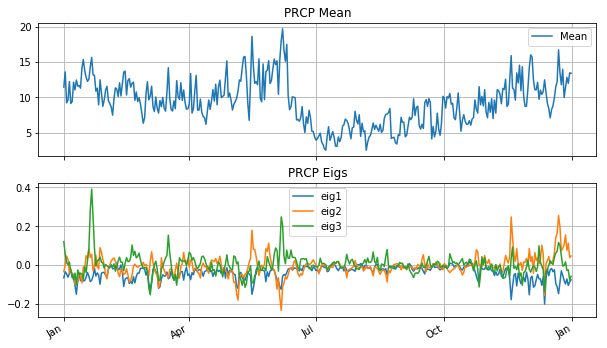

In [8]:
m=meas
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

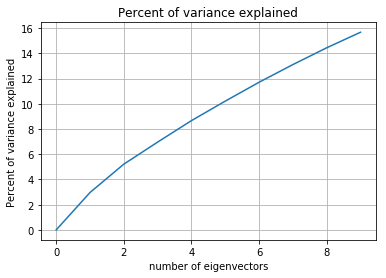

In [9]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [10]:
# A function for plotting the CDF of a given feature
def plot_CDF(df,feat):
    rows=df.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    while len(vals)< len(P):
        vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('fraction of instances')
    xlabel(feat)
    grid()
    

In [11]:
df.show(2)

+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|            coeff_1|            coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|-57.567495307342625|-24.700291626733232|-10.557252674414315|   1617.0|SBSSBBBS|    43.4|   -111.3|       PRCP|0.9916533576687857|0.9900921178102314|0.9898062638530625|0.8663156540329706|USC00104588| 490308.0|    21|[00 00 00 00 00 0...|1938.0|
| -57.93524664828274

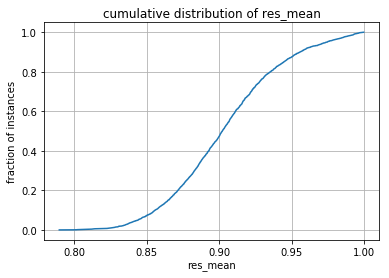

In [12]:
plot_CDF(df,'res_mean')

In [13]:
rows=df.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()
rows[0][:2]

(u'USC00104588', 1938.0)

In [14]:
days=set([r[1] for r in rows])
miny=min(days)
maxy=max(days)
record_len=int((maxy-miny+1)*365)
record_len

43800

In [15]:
## combine the measurements for each station into a single long array with an entry for each day of each day
All={}  # a dictionary with a numpy array for each day of each day
i=0
for station,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((day-miny)*365)
    All[station][loc:loc+365]=vector

In [16]:
from datetime import date
d=datetime.date(int(miny), month=1, day=1)
start=d.toordinal()
print start
dates=[date.fromordinal(i) for i in range(start,start+record_len)]
print dates[:5]
print dates[-5:]

691040
[datetime.date(1893, 1, 1), datetime.date(1893, 1, 2), datetime.date(1893, 1, 3), datetime.date(1893, 1, 4), datetime.date(1893, 1, 5)]
[datetime.date(2012, 11, 28), datetime.date(2012, 11, 29), datetime.date(2012, 11, 30), datetime.date(2012, 12, 1), datetime.date(2012, 12, 2)]


In [17]:
for station in All:
    print station, np.count_nonzero(~np.isnan(All[station]))

USS0011F02S 3545
USC00105716 12932
USC00107210 2515
USS0014F16S 5717
USW00024156 26270
USW00024142 17459
USC00100375 18158
USC00100915 28609
USC00100218 1399
USC00109601 5326
USS0013F03S 6762
USS0014F08S 5355
USS0011G01S 6037
USC00108906 12664
USC00106877 19360
USC00108380 33020
USS0013F04S 5974
USC00108535 9866
USC00107240 1047
USC00103828 332
USC00107673 30736
USC00102260 17887
USC00104845 13647
USC00105143 3894
USC00105972 5012
US1IDPW0001 1052
USC00104670 31780
USC00109900 703
USW00004110 4312
USC00102676 29493
USS0011F11S 6045
USC00108626 13260
USC00106764 14086
USC00103110 5375
USC00100010 26173
USC00105724 1083
USS0013F09S 5333
USC00105980 19114
USC00107721 1033
USC00103940 710
USW00024145 18950
USC00107208 10479
USC00109658 5280
USC00100227 29995
USC00104455 14859
USC00104456 20037
USS0012G17S 4652
USW00094143 16306
US1IDBK0001 1458
USC00107040 19099
USC00103825 10322
USC00108937 18319
USS0013F13S 330
USC00103942 23555
USC00104230 2781
US1IDBV0006 1095
USC00103580 365
USC001076

In [18]:
Stations=sorted(All.keys())
A=[]
for station in Stations:
    A.append(All[station])

day_station_table=np.hstack([A])
print shape(day_station_table)

(75, 43800)


In [19]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_day=np.nanmean(day_station_table,axis=0)
# print mean_by_day.shape
mean_by_station=np.nanmean(day_station_table,axis=1)
tbl_minus_day = day_station_table-mean_by_day
tbl_minus_station = (day_station_table.transpose()-mean_by_station).transpose()

print 'total RMS                   = ',RMS(day_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-day   = ',RMS(tbl_minus_day)

total RMS                   =  31.7058266099
RMS removing mean-by-station=  30.0100251837
RMS removing mean-by-day   =  23.2405346415


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


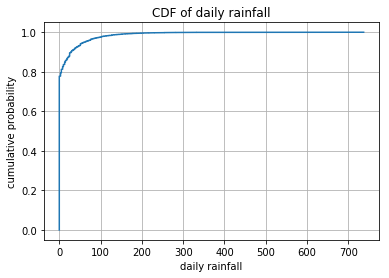

In [20]:
RT=day_station_table
F=RT.flatten()
NN=F[~np.isnan(F)]

NN.sort()
P=np.arange(0.,1.,1./len(NN))
plot(NN,P)
grid()
title('CDF of daily rainfall')
xlabel('daily rainfall')
ylabel('cumulative probability')

In [21]:
Stations

[u'US1IDBK0001',
 u'US1IDBV0006',
 u'US1IDCR0001',
 u'US1IDPW0001',
 u'USC00100010',
 u'USC00100218',
 u'USC00100227',
 u'USC00100375',
 u'USC00100915',
 u'USC00100920',
 u'USC00101220',
 u'USC00101667',
 u'USC00102071',
 u'USC00102260',
 u'USC00102676',
 u'USC00102823',
 u'USC00103110',
 u'USC00103297',
 u'USC00103580',
 u'USC00103825',
 u'USC00103828',
 u'USC00103882',
 u'USC00103940',
 u'USC00103942',
 u'USC00104230',
 u'USC00104455',
 u'USC00104456',
 u'USC00104588',
 u'USC00104670',
 u'USC00104845',
 u'USC00105143',
 u'USC00105510',
 u'USC00105640',
 u'USC00105678',
 u'USC00105716',
 u'USC00105724',
 u'USC00105972',
 u'USC00105980',
 u'USC00106764',
 u'USC00106877',
 u'USC00106930',
 u'USC00107040',
 u'USC00107208',
 u'USC00107210',
 u'USC00107240',
 u'USC00107673',
 u'USC00107689',
 u'USC00107721',
 u'USC00107727',
 u'USC00107968',
 u'USC00108380',
 u'USC00108535',
 u'USC00108626',
 u'USC00108906',
 u'USC00108937',
 u'USC00109601',
 u'USC00109658',
 u'USC00109900',
 u'USC00480124

### Conclusions
It is likely to be hard to find correlations between the **amount** of rain on the same day in different stations. Because amounts of rain vary a lot between even close locations. It is more reasonable to try to compare whether or not it rained on the same day in different stations. As we see from the graph above, in our region it rains in about one third of the days.

### measuring statistical significance
We want to find a statistical test for rejecting the null hypothesis that says that the rainfall in the two locations is independent.

Using the inner product is too noisy, because you multiply the rainfall on the same day in two locations and that product can be very large - leading to a large variance and poor ability to discriminate.

An alternative is to ignore the amount of rain, and just ask whether it rained in both locations. We can then compute the probability associated with the number of overlaps under the null hypothesis.

Fix two stations. We restrict our attention to the days for which we have measurements for both stations, and define the following notation:
* $m$ : the total number of days (for which we have measurements for both stations).
* $n_1$ : the number of days that it rained on station 1
* $n_2$ : the number of days that it rained on station 2
* $l$ : the number of days that it rained on both stations.

We want to calculate the probability that the number of overlap days is $l$ given $m,n_1,n_2$.

The answer is:
$$
P = {m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} /{m \choose n_1}{m \choose n_2}
$$

Where
$$
{m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} = \frac{m!}{l! (n_1-l)! (n_2-l)! (m-n_1-n_2+l)!}
$$

We use the fact that $\Gamma(n+1) = n!$ and denote $G(n) \doteq \log \Gamma(n+1)$
$$
\log P = \left[G(m) - G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) \right] - 
\left[G(m)-G(n_1)-G(m-n_1)\right] - \left[G(m)-G(n_2)-G(m-n_2)\right]
$$
Which slightly simplifies to 
$$
\log P = -G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) - G(m)+G(n_1)+G(m-n_1) +G(n_2)+G(m-n_2)
$$

The log probability scales with $m$ the length of the overlap. So to get a per-day significance we consider $
\frac{1}{m} \log P $

In [22]:
from scipy.special import gammaln,factorial
#for i in range(10):
#    print exp(gammaln(i+1))-factorial(i)
def G(n):
    return gammaln(n+1)
def LogProb(m,l,n1,n2):
    logP=-G(l)-G(n1-l)-G(n2-l)-G(m-n1-n2+l)-G(m)+G(n1)+G(m-n1)+G(n2)+G(m-n2)
    return logP/m
exp(LogProb(1000,250,500,500))

0.99701718564583286

In [23]:
#USC00193270 21482
#USC00193702 28237
X=copy(All['USC00104845'])
Y=copy(All['USC00107040'])
print sum(~np.isnan(X))
print sum(~np.isnan(Y))
X[np.isnan(Y)]=np.nan
Y[np.isnan(X)]=np.nan
print sum(~np.isnan(X))
print sum(~np.isnan(Y))


13647
19099
13470
13470


In [24]:
Y[~np.isnan(Y)][:10]

array([  0.,   0.,   0.,   0.,  25.,   0.,   0.,   0.,   0.,   0.])

In [25]:
def computeLogProb(X,Y):
    X[np.isnan(Y)]=np.nan
    Y[np.isnan(X)]=np.nan
    G=~isnan(X)
    m=sum(G)
    XG=X[G]>0
    YG=Y[G]>0
    n1=sum(XG)
    
    n2=sum(YG)
    l=sum(XG*YG)
#     print l, n1, n2
    logprob=LogProb(m,l,n1,n2)
    # print 'm=%d,l=%d,n1=%d,n2=%d,LogPval=%f'%(m,l,n1,n2,logprob)
    return logprob,m
print computeLogProb(X,Y)

(-0.12556389897433048, 13470)


### calculate the normalized log probability for each pair of stations.

In [26]:
L=len(Stations)
Pvals=np.zeros([L,L])
Length=np.zeros([L,L])
P_norm=np.zeros([L,L])
for i in range(L):
    print i,
    for j in range(L):
        if i==j: 
            P_norm[i,j]=-0.4
            continue
        X=copy(All[Stations[i]])
        Y=copy(All[Stations[j]])
        P_norm[i,j],Length[i,j]=computeLogProb(X,Y)
        if Length[i,j]<200:
            P_norm[i,j]=np.nan

            

0 1 2 3 4 5 6 7 8 9 10

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74


In [27]:
print Pvals[:10,:10]
print Length[:2,:2]
print P_norm[:10,:10]
print len(Pvals)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[    0.  1093.]
 [ 1093.     0.]]
[[-0.4        -0.21398623 -0.18123904 -0.25021716 -0.16066515 -0.11660446
          nan -0.03308132 -0.22804791         nan]
 [-0.21398623 -0.4        -0.17833636 -0.18026361 -0.12771796 -0.08949753
          nan -0.03878026 -0.21717628         nan]
 [-0.18123904 -0.17833636 -0.4        -0.15746622 -0.10810456 -0.07214798
          nan -0.02352993 -0.15916207         nan]
 [-0.25021716 -0.18026361 -0.15746622 -0.4        -0.22684084 -0.13732434
          nan -0.04952579 -0.23523961         nan]
 [-0.16066515 -0.12771796 -0.10810

(5625,) (3417,)


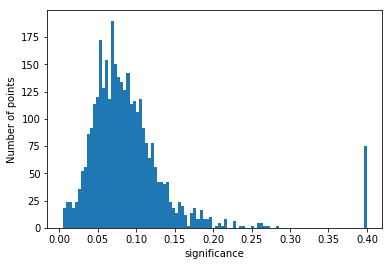

In [29]:
A=P_norm.flatten();
B=A[~isnan(A)]
print A.shape,B.shape
hist(-B,bins=100);
xlabel('significance')
ylabel('Number of points')

In [32]:
def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(10,10))
    axes.imshow(mat, cmap=plt.cm.gray)
    title("P-value between pair of stations")

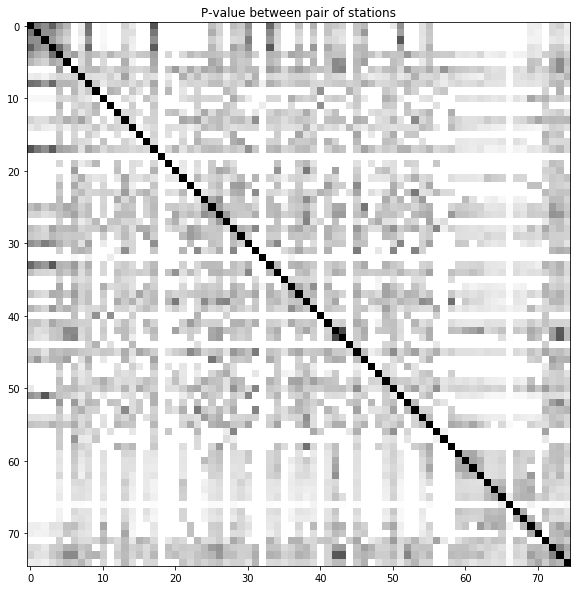

In [33]:
showmat(P_norm)

### Finding structure in the rependency matrix.
The matrix above shows, for each pair of stations, the normalized log probability that the overlap in rain days is random.

We see immediately the first 8 stations are highly correlatedwith each other. 

To find more correlations we use SVD (the term PCA is reserved for decomposition of the covariance matrix). As we shall see that the top 10 eigenvectors explain about 80% of the square magnitude of the matrix.

In [35]:
print 'A group of very correlated stations is:',All.keys()[:8]

A group of very correlated stations is: [u'USS0011F02S', u'USC00105716', u'USC00107210', u'USS0014F16S', u'USW00024156', u'USW00024142', u'USC00100375', u'USC00100915']


[ 0.05739911  0.03780971  0.02688231  0.01828956  0.01417571  0.01337642
  0.00806654  0.00727858  0.0064933   0.00545714]


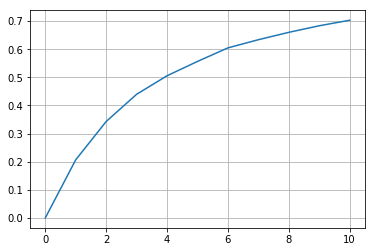

In [36]:
from sklearn.decomposition import PCA
P_norm0 = np.nan_to_num(P_norm)
n_comp=10
pca = PCA(n_components=n_comp)
pca.fit(P_norm0)     
print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
plot(insert(cumsum(Var_explained),0,0))
grid()

In [37]:
# we will look only at the top 4 eigenvectors.
n_comp=4
pca = PCA(n_components=n_comp)
pca.fit(P_norm0)     

PCA(copy=True, n_components=4, whiten=False)

(4, 75)
75


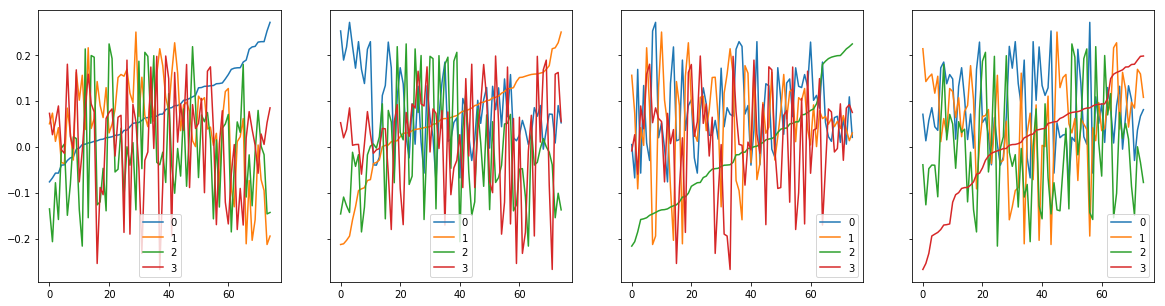

In [38]:
fig,axes=plt.subplots(1,4,figsize=(20,5),sharey='row');
L=list(pca.components_.transpose())
print pca.components_.shape
print len(L)
def column(matrix, i):
    return [row[i] for row in matrix]
for i in range(4):
    X=sorted(L,key=lambda x:x[i])
    
#     print X
#     print
#     print len(X), len(X[0])
    for j in range(4):
        X_ = column(X,j)
        axes[i].plot(X_,label=str(j));
    axes[i].legend()
#     axes[i].legend([0,1,2,3],['1','2','3','4']);

In [39]:
def re_order_matrix(M,order):
    M_reord=M[order,:]
    M_reord=M_reord[:,order]
    return M_reord

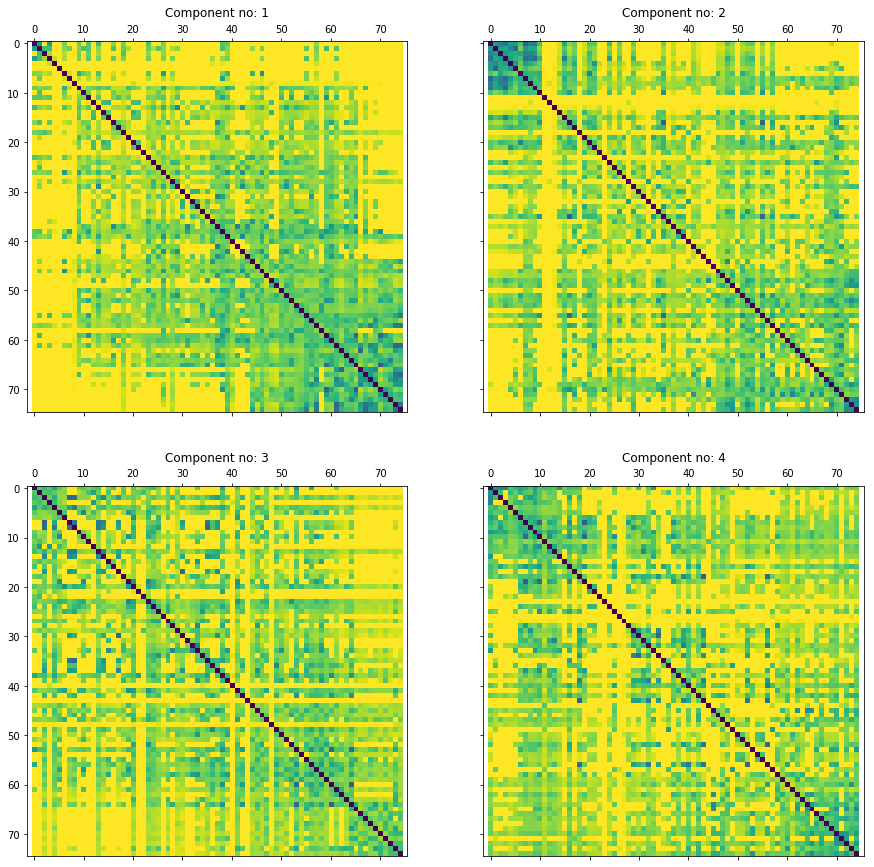

In [64]:
fig,axes=plt.subplots(2,2,figsize=(15,15),sharex='col',sharey='row');
i=0
orderArr = []
title("Decomposition of p-value matrix for pairs of stations")
for r in range(2):
    for c in range(2):
        order=np.argsort(pca.components_[i,:])
        orderArr.append(order)
        P_norm_reord=re_order_matrix(P_norm0,order)
        i+=1
        axes[r,c].title.set_text("Component no: "+str(i))
        axes[r,c].matshow(P_norm_reord)
# title("Decomposition of p-value matrix for pairs of stations")

### Explanation and possibe extensions
When we reorder the rows and columns of the matrix using one of the eigenvectors, the grouping of the 
stations becomes more evident. For example, consider the upper left corner of the scond matrix (The upper left one). The stations at positions 0-22 are clearly strongly correlated with each other. Even though there are some stations, in positions 15-18 or so, which are more related to each other than to the rest of this block.

This type of organization is called **Block Diagonal** and it typically reveals important structure such as grouping or clustering.

You might want to extract the sets of stations that form blocks for your region, and then plot them on the map to see their spatial relationship.

In [65]:
first_order = orderArr[0][-10:]
# second_order = orderArr[1][:10]
print first_order
st_1 = [Stations[i] for i in first_order]
# st_2 = [Stations[i] for i in second_order]
print st_1#, st_2

[42  2 33  1 30 43  5 46  0  3]
[u'USC00107208', u'US1IDCR0001', u'USC00105678', u'US1IDBV0006', u'USC00105143', u'USC00107210', u'USC00100218', u'USC00107689', u'US1IDBK0001', u'US1IDPW0001']


In [66]:
lat_1 = []
lon_1 = []
pd_df = df.toPandas()
elev_1 = []
for station in st_1:
    lat_vals = pd_df['latitude'].where(pd_df['station'] == station)
    lat_1.append(lat_vals.dropna(axis=0).iloc[0])
    lon_vals = pd_df['longitude'].where(pd_df['station'] == station)
    lon_1.append(lon_vals.dropna(axis=0).iloc[0])
    elev_vals = pd_df['elevation'].where(pd_df['station'] == station)
    elev_1.append(elev_vals.dropna(axis=0).iloc[0])
#     lat.append(pd_df['latitude'].where(pd_df['station'] == station))
#     lon.append(pd_df['longitude'].where(pd_df['station'] == station))
# lat_2 = []
# lon_2 = []
# elev_2 = []
# for station in st_2:
#     lat_vals = pd_df['latitude'].where(pd_df['station'] == station)
#     lat_2.append(lat_vals.dropna(axis=0).iloc[0])
#     lon_vals = pd_df['longitude'].where(pd_df['station'] == station)
#     lon_2.append(lon_vals.dropna(axis=0).iloc[0])
#     elev_vals = pd_df['elevation'].where(pd_df['station'] == station)
#     elev_2.append(elev_vals.dropna(axis=0).iloc[0])
# # print elev_1
# print elev_2
# print np.std(elev_1)
# print np.mean(elev_1)
# print np.mean(elev_2)
# print np.std(elev_2)

In [67]:
# plt.boxplot(elev_2, 0, 'rs', 0)
# plt.figure()

In [68]:
# plt.boxplot(elev_1, 0, 'rs', 0)
# plt.figure()

In [69]:
all_evals = []
for s in Stations:
    elev_vals = pd_df['elevation'].where(pd_df['station'] == s)
    all_evals.append(elev_vals.dropna(axis=0).iloc[0])
# plt.boxplot(all_evals, 0, 'rs', 0)
# print np.mean(all_evals)
# print np.std(all_evals)

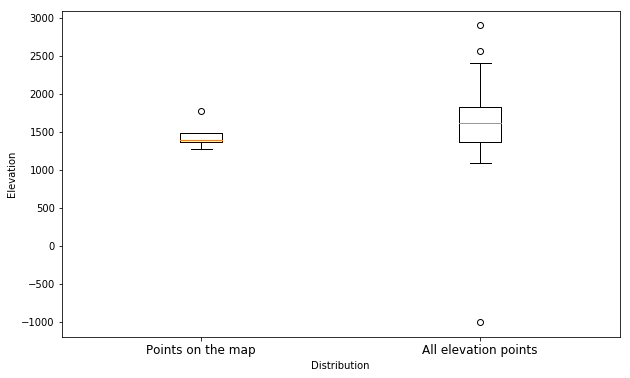

In [70]:
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.boxplot([elev_1, all_evals])
plt.xlabel("Distribution")
plt.ylabel("Elevation")
labels = ["Points on the map","All elevation points"]
xtickNames = plt.setp(ax1, xticklabels=labels)
plt.setp(xtickNames, rotation=0, fontsize=12)
plt.figure()

In [71]:
from scipy import stats
print stats.kruskal(elev_1, all_evals)

KruskalResult(statistic=2.6793839418340726, pvalue=0.10165504723538911)


In [73]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)
from leaflet import *

In [83]:
min_lat,max_lat,min_long,max_long = box = (42.4198, 44.1176, -110.4735, -114.8840)
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 7

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []

for l1, l2 in zip(lat_1,lon_1):
    _lat=l1
    _long=l2
    c = Circle(location=(_lat,_long), radius=50, weight=20,
            color='#ffff00', opacity=0.8,fill_opacity=0.8, fill_color='#ffff00')
    circles.append(c)
    m.add_layer(c)
    
# circles = []

# for l1, l2 in zip(lat_2,lon_2):
#     _lat=l1
#     _long=l2
#     c = Circle(location=(_lat,_long), radius=int(2.0), weight=10,
#             color='#ff0000', opacity=0.8,fill_opacity=0.4
#             )
#     circles.append(c)
#     m.add_layer(c)
    
m

In [116]:
min_lat,max_lat,min_long,max_long = box = (42.4198, 44.1176, -110.4735, -114.8840)
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 8

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
# circles = []

# for l1, l2 in zip(lat_1,lon_1):
#     _lat=l1
#     _long=l2
#     c = Circle(location=(_lat,_long), radius=50, weight=10,
#             color='#00ff00', opacity=0.8,fill_opacity=0.1, fill_color='#00ff00')
#     circles.append(c)
#     m.add_layer(c)
    
circles = []

for l1, l2 in zip(lat_2,lon_2):
    _lat=l1
    _long=l2
    c = Circle(location=(_lat,_long), radius=int(2.0), weight=10,
            color='#ff0000', opacity=0.8,fill_opacity=0.4
            )
    circles.append(c)
    m.add_layer(c)
    
m

In [35]:
from pickle import dump
with open(data_dir+'/PRCP_residuals_PCA.pickle','wb') as file:
    dump({'stations':All.keys(),
          'eigen-vecs':pca.components_},
        file)
    

In [36]:
sc.stop()